# CFPB Complaints Analysis

This project analyzes consumer complaint narratives from the CFPB dataset to:
1. Preprocess text data to clean and prepare it for analysis
2. Discover complaint topics using LDA
3. Build a neural network to predict these topics

Essentially, I want to see if I can separate complaints into topics based on their content.

### Rationale

Semantic analysis on complaints could help sort them where user selection falls short. Furthermore, a semantic analysis of complaints could help derive specific issue frequency, like, is X company screwing over a lot of people, is Y bank uncooperative with people, etc. etc.

## 1. Import Libraries and Load Data

Download data from https://files.consumerfinance.gov/ccdb/complaints.csv.zip.

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from gensim import corpora, models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline

/var/folders/p3/2vnff0lj0j16r1y6_bsb8b840000gn/T/ipykernel_421/1278863269.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/cameron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cameron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/cameron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('complaints_truncated.csv')

print(f"Dataset shape: {df.shape}")
print("\nDataset preview:")
df.head()

Dataset shape: (137857, 1)

Dataset preview:


,Consumer complaint narrative
0,"Commencing on or about XXXX to XX/XX/year>, I ..."
1,XXXX XXXX XXXX XXXX XXXX XXXX Phone : ( XXXX )...
2,"I'm just mailing you to let you know, respectf..."
3,"I am filing a complaint against Equifax, Exper..."
4,Had money deposit into the account from my ret...


## 2. Text Preprocessing

In [4]:
def preprocess_text(text) -> str:
    """
    Preprocess text data for NLP analysis with regards to CFPB complaint content.
    """

    if isinstance(text, str):
        text = re.sub(r'\{\$\d+(\.\d+)?\}', 'AMOUNT', text) # hate regex, still love regex though
        
        text = re.sub(r'X{2,}(/X{2,})?(\s*X{2,})*', '', text) # redactions
        
        text = re.sub(r'\d+\s*U\.S\.C\.\s*\d+(\w*)?(\s*\(\s*\d+\s*\))?', 'LAW_CITATION', text)
        
        text = re.sub(r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}', 'EMAIL', text) # in case of unredacted PII
        text = re.sub(r'\(\s*\d{3,4}\s*\)\s*\d{3,4}', 'PHONE', text)
        
        proper_nouns = ['wells fargo', 
                        'bank of america', 
                        'chase', 
                        'equifax', 
                        'experian', 
                        'transunion', 
                        'usaa', 
                        'capital one', 
                        'citibank',
                        'paypal',
                        'zelle',
                        'cash app',
                        'venmo',
                        ] # to double make sure these are not removed, though not expansive
        for proper_noun in proper_nouns:
            text = text.replace(proper_noun.lower(), proper_noun.replace(' ', '_'))
        
        text = re.sub(r'[^a-zA-Z\s\.]', ' ', text)
        text = text.lower()
        
        tokens = nltk.word_tokenize(text)
        
        stop_words = set(stopwords.words('english'))
        complaint_stops = {'would', 'could', 'please', 'said', 'told', 'sincerely', 'kindly',
                        'request', 'accordance', 'pursuant', 'regarding', 'despite'} # law words with specific intent -- somewhat important to keep
        stop_words.update(complaint_stops)
        
        tokens = [word for word in tokens if (word not in stop_words and len(word) > 2) 
                 or word in ['fee', 'tax', 'due', 'pay', 'loan', 'debt']] # finance stuff
        
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        
        processed_text = ' '.join(tokens)
        
        processed_text = re.sub(r'\s+', ' ', processed_text).strip()
        
        return processed_text
    return ''

In [5]:
df["ProcessedText"] = df["Consumer complaint narrative"].apply(preprocess_text)
print("Processed data.")

print("Processed sample:")
for i in range(3):
    print(f"Original: {df['Consumer complaint narrative'].iloc[i][:100]}...")
    print(f"Processed: {df['ProcessedText'].iloc[i][:100]}...")
    print()

Processed data.
Processed sample:
Original: Commencing on or about XXXX to XX/XX/year>, I fell victim to two multi-layered scam operations run b...
Processed: commencing year fell victim two multi layered scam operation run involved making deposit total amoun...

Original: XXXX XXXX XXXX XXXX XXXX XXXX Phone : ( XXXX ) XXXX Email : XXXX [ Date ] To the Georgia Insurance R...
Processed: phone email date georgia insurance regulator writing file formal complaint demand immediate investig...

Original: I'm just mailing you to let you know, respectfully, that you are incorrectly reporting some informat...
Processed: mailing let know respectfully incorrectly reporting information credit report pretty angry right hon...



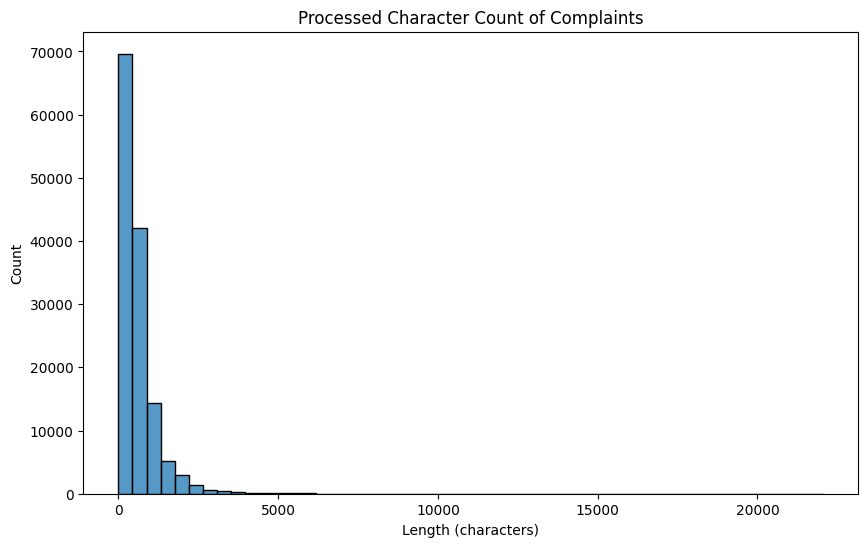

count    137857.000000
mean        590.896422
std         716.797413
min           0.000000
25%         192.000000
50%         432.000000
75%         679.000000
max       22048.000000
Name: text_length, dtype: float64

In [6]:
df['text_length'] = df['ProcessedText'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50)
plt.title('Processed Character Count of Complaints')
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.show()

df['text_length'].describe()

## 3. LDA Topic Modeling

In [7]:
processed_texts = df['ProcessedText'].tolist()
texts = [text.split() for text in processed_texts if text.strip()]

dictionary = corpora.Dictionary(texts)
print(f"Number of unique tokens before filtering: {len(dictionary)}")

dictionary.filter_extremes(no_below=5, no_above=0.7)
print(f"Number of unique tokens after filtering: {len(dictionary)}")

corpus = [dictionary.doc2bow(text) for text in texts]

Number of unique tokens before filtering: 30988
Number of unique tokens after filtering: 10152


In [8]:
num_topics = 11 # 3-to-12 optimal
print(f"Using {num_topics} topics:")

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=20,
    alpha='auto',
    random_state=42 # standard
)

print("\nTopics identified by LDA model:")
topics_dict = {}
for topic_id, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {topic_id}: {topic}")
    topics_dict[topic_id] = topic

Using 11 topics:

Topics identified by LDA model:
Topic 0: 0.049*"code" + 0.043*"u.s." + 0.040*"report" + 0.036*"credit" + 0.031*"violation" + 0.029*"consumer" + 0.026*"reporting" + 0.020*"account" + 0.016*"consent" + 0.013*"fair"
Topic 1: 0.081*"report" + 0.072*"credit" + 0.047*"account" + 0.041*"information" + 0.021*"identity" + 0.019*"theft" + 0.017*"fraudulent" + 0.012*"remove" + 0.011*"name" + 0.011*"removed"
Topic 2: 0.017*"account" + 0.012*"amount" + 0.011*"year" + 0.011*"bank" + 0.010*"loan" + 0.010*"card" + 0.010*"time" + 0.009*"company" + 0.008*"received" + 0.008*"sent"
Topic 3: 0.057*"experian" + 0.044*"consumer" + 0.032*"credit" + 0.025*"disputed" + 0.023*"dispute" + 0.022*"account" + 0.020*"cfpb" + 0.019*"failing" + 0.019*"law" + 0.019*"evidence"
Topic 4: 0.028*"financial" + 0.028*"unfair" + 0.026*"cash" + 0.026*"app" + 0.025*"resolution" + 0.025*"act" + 0.021*"error" + 0.017*"caused" + 0.016*"due" + 0.016*"consumer"
Topic 5: 0.048*"zelle" + 0.034*"concern" + 0.033*"transa

I tested LDA models with 3 to 12 topics in my initial attempt to work with the data and the 11-topic model achieved the best coherence score (C_v approx 0.56). Had to remove the cell itself because it stalled runtime in non-manual testing (i.e. overnight).

Processing topic 0
Found 10 word-weight pairs
Processing topic 1
Found 10 word-weight pairs
Processing topic 2
Found 10 word-weight pairs
Processing topic 3
Found 10 word-weight pairs
Processing topic 4
Found 10 word-weight pairs
Processing topic 5
Found 10 word-weight pairs
Processing topic 6
Found 10 word-weight pairs
Processing topic 7
Found 10 word-weight pairs
Processing topic 8
Found 10 word-weight pairs
Processing topic 9
Found 10 word-weight pairs
Processing topic 10
Found 10 word-weight pairs


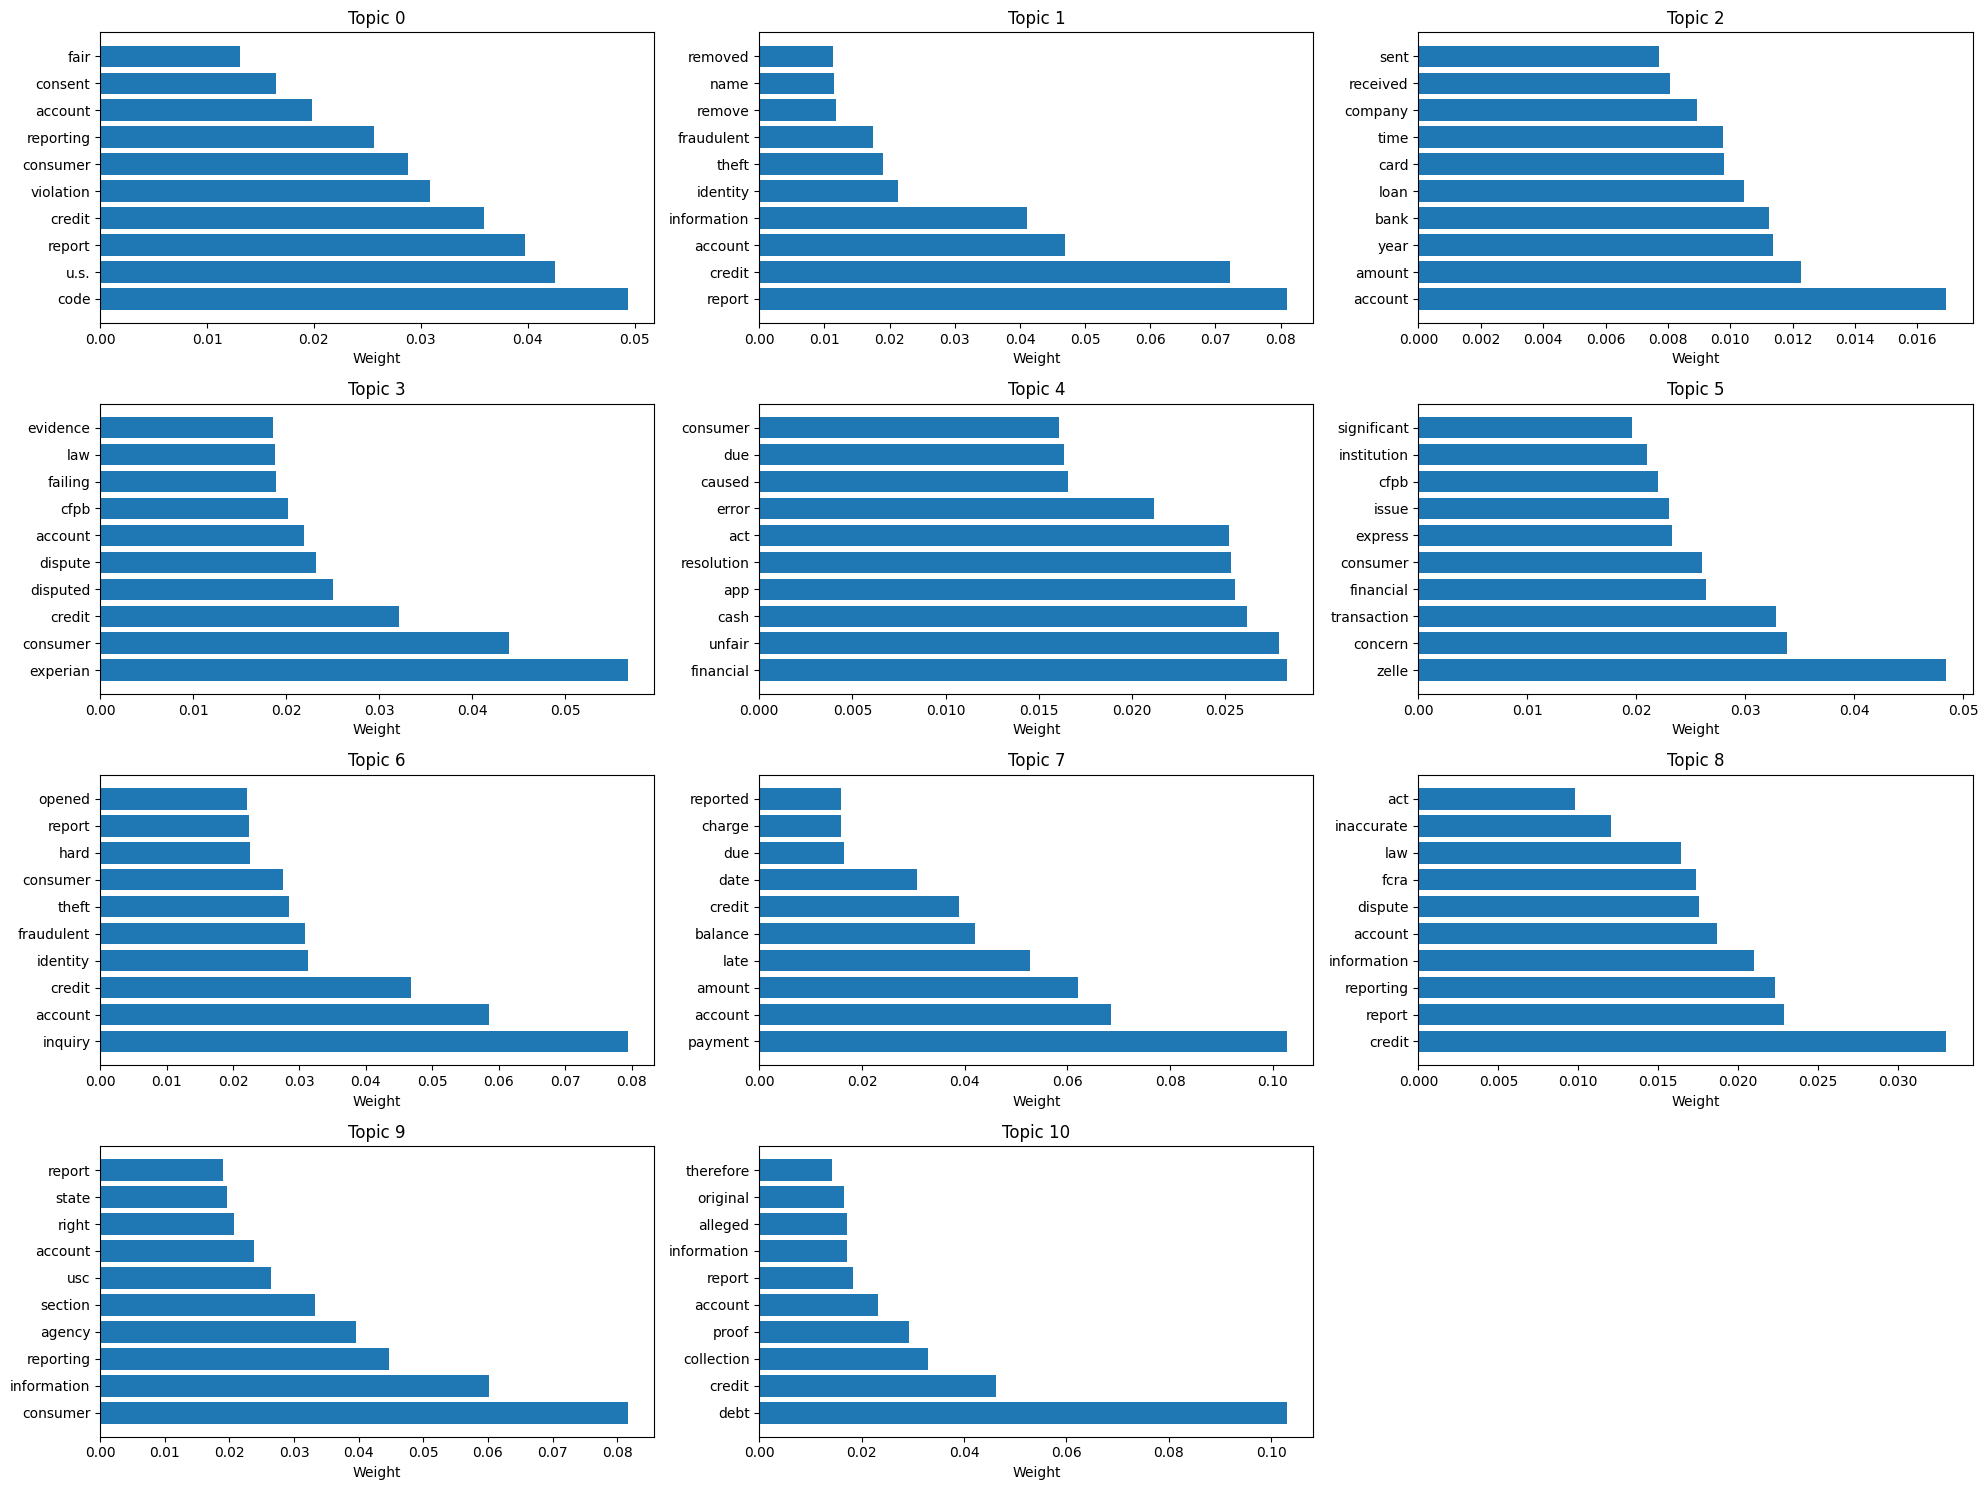

In [9]:
plt.figure(figsize=(20, 15))

for i, topic_id in enumerate(range(num_topics)):
    print(f"Processing topic {topic_id}")
    
    terms = lda_model.show_topic(topic_id, topn=10)
    words, weights = zip(*terms)
    
    print(f"Found {len(words)} word-weight pairs")
    
    ax = plt.subplot(4, 3, i+1)
    
    y_pos = np.arange(len(words))
    ax.barh(y_pos, weights, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words)
    ax.set_xlabel('Weight')
    ax.set_title(f'Topic {topic_id}')

plt.tight_layout()
plt.show()

In [10]:
def get_dominant_topic(text, model, dictionary) -> int:
    """
    Identifies the dominant topic for a given text using LDA model.
    """
    if not text.strip():
        return -1
    
    bow = dictionary.doc2bow(text.split())
    topics = model.get_document_topics(bow)
    
    if not topics:
        return -1
    
    dominant_topic = max(topics, key=lambda x: x[1])[0]
    return dominant_topic

df['Topic'] = df['ProcessedText'].apply(
    lambda x: get_dominant_topic(x, lda_model, dictionary)
)

topic_labels = {
    0: "FCRA Violations",
    1: "Identity Theft",
    2: "General Banking/Transactions",
    3: "Credit Reporting Disputes",
    4: "App Errors",
    5: "Fund Transfer Issues",
    6: "Credit Fraud",
    7: "Late Fees and Balance Reporting",
    8: "Credit Report Accuracy",
    9: "Consumer Rights",
    10: "Debt Collection",
}

df["TopicLabel"] = df["Topic"].map(topic_labels)
df[["ProcessedText", "Topic", "TopicLabel"]].head(20)

,ProcessedText,Topic,TopicLabel
0,commencing year fell victim two multi layered ...,2,General Banking/Transactions
1,phone email date georgia insurance regulator w...,2,General Banking/Transactions
2,mailing let know respectfully incorrectly repo...,8,Credit Report Accuracy
3,filing complaint equifax experian transunion f...,3,Credit Reporting Disputes
4,money deposit account retirement account wont ...,2,General Banking/Transactions
5,year reported point score.inquiry made,2,General Banking/Transactions
6,hard pull credit flagship credit acceptance ga...,2,General Banking/Transactions
7,complaint serf formal legally binding demand i...,8,Credit Report Accuracy
8,year fraudulent charge amount made citibank cr...,2,General Banking/Transactions
9,account never recieved letter notification com...,2,General Banking/Transactions


The topic labels are somewhat approximate, there may still be subtopics within some clusters or potential for broader grouping. Specifically, 0, 3 and 8 seem to overlap, and 2 is very broad.

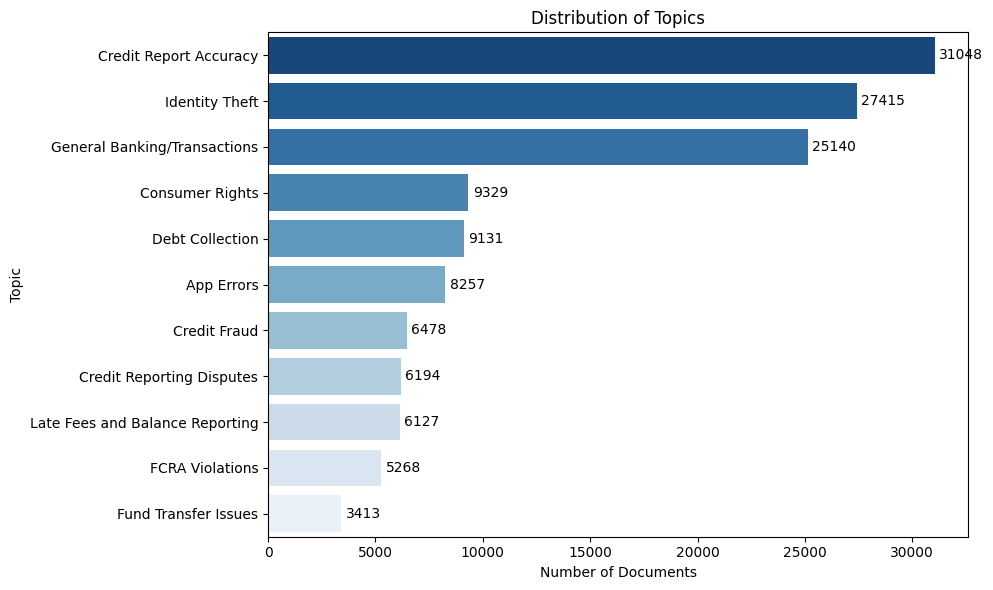

In [11]:
plt.figure(figsize=(10, 6))

topic_counts = df["TopicLabel"].value_counts()

ax = sns.barplot(
    y=topic_counts.index,
    x=topic_counts.values,
    hue=topic_counts.index.astype(str),
    legend=False,
    palette="Blues_r",
)

plt.title("Distribution of Topics")
plt.xlabel("Number of Documents")
plt.ylabel("Topic")

for i, count in enumerate(topic_counts.values):
    ax.text(count + 200, i, str(count), va="center") # nums for bars

plt.tight_layout()
plt.show()

## 4. Neural Network

### Hyper-parameters

- **Hidden layers**: 128 -> 64 units
- **Activation**: ReLU
- **Dropout**: 0.30 (both layers)
- **L2 regularization**: 0.001
- **Batch size**: 128
- **Optimizer**: Adam, learning rate = 5e-4
- **LR scheduler**: ReduceLROnPlateau (factor = 0.5, patience = 3)

In [12]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['ProcessedText']).toarray()
y = df['Topic']

invalid_labels = (y == -1).sum()
print(f"Found {invalid_labels} invalid documents.")

valid_indices = y != -1
X = X[valid_indices]
y = y[valid_indices]
print(f"Filtered dataset shape: {X.shape}")

print(f"Feature matrix shape: {X.shape}")

Found 57 invalid documents.
Filtered dataset shape: (137800, 5000)
Feature matrix shape: (137800, 5000)


In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 96460
Validation set size: 20670
Test set size: 20670


In [14]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}
print(f"Class weights: {class_weight_dict}")

X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train.values, dtype=tf.int32)
X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tf = tf.convert_to_tensor(y_val.values, dtype=tf.int32)

Class weights: {0: 2.386796654624635, 1: 0.4587304304818429, 2: 0.49983418314471667, 3: 2.014030985092078, 4: 1.5137391522684118, 5: 3.5588842975206614, 6: 1.956512920368342, 7: 2.042648709315376, 8: 0.40278769505722795, 9: 1.3314744775418932, 10: 1.3738196630253656}


In [15]:
class ComplaintsNN(tf.keras.Model):
    def __init__(self, input_dim, hidden_size1=128, hidden_size2=64, num_classes=9):
        super(ComplaintsNN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_size1, activation='relu', kernel_regularizer=l2(0.001))
        self.dropout1 = tf.keras.layers.Dropout(0.3)
        
        self.dense2 = tf.keras.layers.Dense(hidden_size2, activation='relu', kernel_regularizer=l2(0.001))
        self.dropout2 = tf.keras.layers.Dropout(0.3)
        
        self.dense3 = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
        
    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dropout1(x, training=training)
            
        x = self.dense2(x)
        x = self.dropout2(x, training=training)
            
        return self.dense3(x)
    
    def build(self, input_shape):
        super().build(input_shape) # warning fix

In [16]:
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = ComplaintsNN(input_dim=input_dim, num_classes=num_classes)

model.build(input_shape=(None, input_dim))

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

In [17]:
checkpoint_dir = './model_checkpoints'
Path(checkpoint_dir).mkdir(exist_ok=True)
checkpoint_path = f"{checkpoint_dir}/best_model.keras"

epochs = 20
batch_size = 128
steps_per_epoch = len(X_train) // batch_size

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}
print(f"Class weights: {class_weight_dict}")

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callbacks = [ # some overfitting prevention
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, min_delta=1e-3
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, monitor='val_loss', save_best_only=True
    )
]

print("Starting model training...")
history = model.fit(
    X_train_tf, y_train_tf,
    validation_data=(X_val_tf, y_val_tf),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(f"Training complete. Model trained for {len(train_loss)} epochs.")

Class weights: {0: 2.386796654624635, 1: 0.4587304304818429, 2: 0.49983418314471667, 3: 2.014030985092078, 4: 1.5137391522684118, 5: 3.5588842975206614, 6: 1.956512920368342, 7: 2.042648709315376, 8: 0.40278769505722795, 9: 1.3314744775418932, 10: 1.3738196630253656}
Starting model training...
Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7191 - loss: 1.3419 - val_accuracy: 0.9398 - val_loss: 0.5315 - learning_rate: 5.0000e-04
Epoch 2/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9127 - loss: 0.5292 - val_accuracy: 0.9411 - val_loss: 0.4959 - learning_rate: 5.0000e-04
Epoch 3/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9189 - loss: 0.4968 - val_accuracy: 0.9430 - val_loss: 0.4860 - learning_rate: 5.0000e-04
Epoch 4/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9217 - loss: 0.4835 - val_accuracy: 0.9429 - val_loss: 0.4790 - learning_rate: 5.0000e-04
Epoch 5/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9238 - loss: 0

## 5. Model Evaluation and Visualization

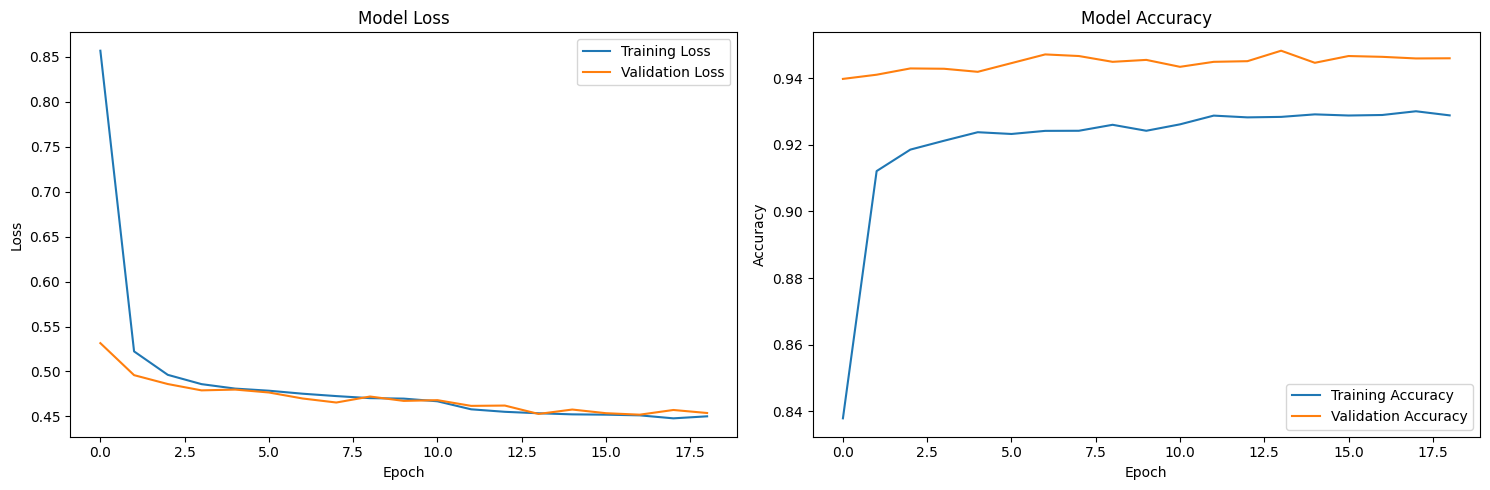

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_acc, label='Training Accuracy')
ax2.plot(val_acc, label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [19]:
def evaluate_model(model, X, y):
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.int32)
    
    results = model.evaluate(X_tf, y_tf, verbose=1)
    
    metrics_names = model.metrics_names
    print("\nTest metrics:")
    for name, value in zip(metrics_names, results):
        print(f"{name}: {value}")
    
    return results

evaluate_model(model, X_test, y_test.values)

646/646 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9489 - loss: 0.4484

Test metrics:
loss: 0.4518091082572937
compile_metrics: 0.9489114880561829


[0.4518091082572937, 0.9489114880561829]

In [20]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

646/646 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       787
           1       0.94      0.94      0.94      4141
           2       0.95      0.94      0.94      3740
           3       0.97      0.98      0.98       887
           4       1.00      1.00      1.00      1247
           5       0.98      0.99      0.99       485
           6       0.89      0.95      0.92      1012
           7       0.83      0.97      0.89       920
           8       0.97      0.93      0.95      4705
           9       0.97      0.97      0.97      1364
          10       0.93      0.96      0.94      1382

    accuracy                           0.95     20670
   macro avg       0.95      0.96      0.95     20670
weighted avg       0.95      0.95      0.95     20670



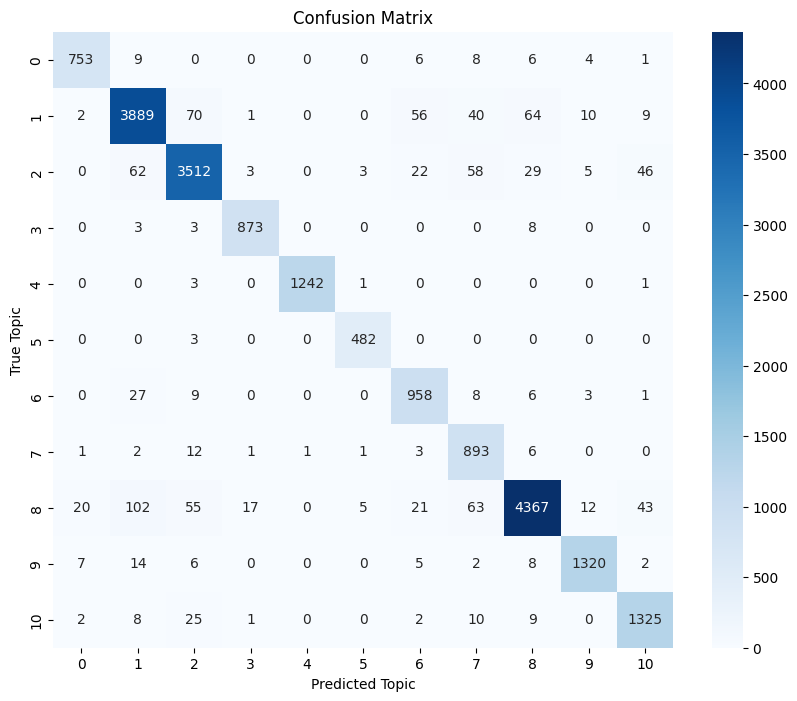

In [21]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Topic')
plt.ylabel('True Topic')
plt.show()

In [22]:
def sample_predictions(X, y_true, model, df, n=5):
    indices = np.random.choice(range(len(X)), size=n, replace=False)
    X_sample = X[indices]
    y_true_sample = y_true.iloc[indices].values
    
    y_pred = model.predict(X_sample)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_pred_probs = np.max(y_pred, axis=1)
    
    print("\nSample predictions:")
    for i in range(n):
        original_text = df['Consumer complaint narrative'].iloc[indices[i]]
        if len(original_text) > 100:
            original_text = original_text[:100] + "..."
            
        print(f"Text: {original_text}")
        print(f"True topic: {y_true_sample[i]}")
        print(f"Predicted topic: {y_pred_classes[i]} (confidence: {y_pred_probs[i]})")
        print("-" * 80)

sample_predictions(X_test, y_test, model, df, n=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Sample predictions:
Text: Unauthorized XXXX transactions with several of my bank accounts ( XXXXXXXX XXXX, Bank of America che...
True topic: 6
Predicted topic: 6 (confidence: 0.9992966651916504)
--------------------------------------------------------------------------------
Text: Dear Sir/Madam, I am writing to dispute certain information on my credit report that was affected by...
True topic: 8
Predicted topic: 8 (confidence: 0.5624871850013733)
--------------------------------------------------------------------------------
Text: I am formally disputing the following negative items on my credit report : XXXX XXXX XXXX XXXX XXXX ...
True topic: 8
Predicted topic: 3 (confidence: 0.38294437527656555)
--------------------------------------------------------------------------------


In [23]:
print("Testing model generalization...")

def test_generalization(text, vectorizer, model, dictionary, lda_model):
    processed_text = preprocess_text(text)
    
    true_topic = get_dominant_topic(processed_text, lda_model, dictionary)
    
        
    text_vec = vectorizer.transform([processed_text]).toarray()
    
    pred = model.predict(text_vec)
    pred_topic = np.argmax(pred[0])
    confidence = np.max(pred[0])
    
    return {
        'processed_text': processed_text,
        'true_topic': true_topic,
        'predicted_topic': pred_topic,
        'confidence': confidence,
        'correct': true_topic == pred_topic
    }

test_texts = [ # ai generated complaints, it's the one use case of LLMs that actually saves real time
    "The credit bureau violated the U.S. code by reporting inaccurate information without my consent",
    "I believe there is a violation of the Fair Credit Reporting Act in how my account was handled",
    "The consumer reporting agency failed to follow proper procedures as required by U.S. code",
    "My credit report contains violations of federal consumer protection laws",
    "They failed to obtain my consent before sharing my information, violating reporting regulations",
    
    "Someone stole my identity and opened fraudulent credit accounts in my name",
    "I need these fraudulent accounts removed from my credit report after identity theft",
    "My credit report shows accounts I never opened due to identity theft",
    "I'm requesting removal of fraudulent information from my credit report",
    "My identity was stolen and now my credit report contains accounts I didn't open",
    
    "My bank account was charged an amount I didn't authorize last year",
    "I sent a loan payment to the company but they claim they never received it",
    "The bank took money from my account without proper notification",
    "My credit card company has been charging me fees for the past year",
    "I transferred an amount to my loan account but it wasn't credited on time",
    
    "I disputed an account with Experian but they failed to investigate properly",
    "Experian is not following the law by failing to remove disputed information",
    "I provided evidence to the CFPB about my disputed credit account",
    "The consumer reporting agency is failing to follow dispute procedures",
    "Experian continues to report disputed information without proper investigation",
    
    "The financial app caused an error that resulted in unfair charges",
    "There was a resolution act violation due to errors in the cash app",
    "The financial institution's app has caused multiple errors affecting my account",
    "The cash app experienced an unfair error that caused me financial harm",
    "Due to a consumer app error, I've been unfairly charged multiple times",
    
    "My Zelle transaction was not processed correctly by my financial institution",
    "I have significant concerns about how my Zelle transfer was handled",
    "The financial institution failed to resolve my Zelle transaction issue",
    "I want to express my concern about a failed transaction through Zelle",
    "The CFPB should investigate how this institution handles Zelle transfers",
    
    "There's a fraudulent hard inquiry on my credit report I never authorized",
    "Someone committed identity theft and opened a fraudulent account in my name",
    "I found unauthorized hard inquiries on my consumer credit report",
    "My credit report shows an account was opened through identity theft",
    "I'm a victim of credit fraud with multiple unauthorized inquiries on my report",
    
    "My account was charged a late fee even though I made the payment before the due date",
    "The credit card company reported a late payment despite receiving the amount on time",
    "My account balance is incorrect and they're charging me late fees",
    "They reported a late payment to credit bureaus even though I paid the full amount",
    "The payment was applied to my account but they still charged a late fee on the balance",
    
    "My credit report contains inaccurate information that the agency refuses to correct",
    "The credit reporting agency is violating FCRA by not correcting disputed information",
    "I've disputed inaccurate information on my credit report multiple times",
    "The law requires credit reporting agencies to correct inaccurate information",
    "My account information on my credit report is completely inaccurate",
    
    "The reporting agency violated section 609 of USC regarding consumer information rights",
    "As a consumer, my rights under state and federal reporting laws were violated",
    "The agency failed to provide information I'm entitled to under consumer protection laws",
    "My rights as a consumer were violated when the agency refused to correct my report",
    "According to USC section 623, the information provider violated my consumer rights",
    
    "The debt collector can't provide proof of the original debt they're trying to collect",
    "I requested validation of the alleged debt but received no proof",
    "The collection agency reported a debt to credit bureaus without verifying it's mine",
    "I don't owe this debt and they have no original documentation to prove otherwise",
    "The debt collector added the alleged debt to my credit report without proper verification",
    
    "My identity was stolen and the debt collector is now pursuing me for fraudulent accounts",
    "The bank's Zelle transfer system had an error that caused unfair fees",
    "Experian violated FCRA by failing to investigate my identity theft claim",
    "The credit reporting agency is violating consumer rights by reporting inaccurate payment information",
    "I disputed the late payment on my credit report but the agency failed to correct it",
    "The financial app charged unauthorized fees to my account without consent",
    "The debt collector is reporting fraudulent information to credit bureaus without proof",
    "My bank account shows a Zelle transaction I never authorized, possibly identity theft",
    "The credit bureau violated consumer protection laws by failing to remove inaccurate late payment information"
]

for text in test_texts:
    result = test_generalization(text, vectorizer, model, dictionary, lda_model)
    print(f"Text: {text}")
    print(f"Processed: {result['processed_text'][:50]}...")
    print(f"True topic: {result['true_topic']}")
    print(f"Predicted topic: {result['predicted_topic']} (confidence: {result['confidence']:.4f})")
    print(f"Correct: {result['correct']}")
    print("-" * 80)

Testing model generalization...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Text: The credit bureau violated the U.S. code by reporting inaccurate information without my consent
Processed: credit bureau violated u.s. code reporting inaccur...
True topic: 0
Predicted topic: 0 (confidence: 0.8054)
Correct: True
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Text: I believe there is a violation of the Fair Credit Reporting Act in how my account was handled
Processed: believe violation fair credit reporting act accoun...
True topic: 0
Predicted topic: 0 (confidence: 0.5711)
Correct: True
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Text: The consumer reporting agency failed to follow proper procedures as required by U.S. code
Processed: consumer reporting agency failed follow proper pro...
True topic: 0
Predicted topic: 0 (confidence: 0.8217)
Correct: 

In [24]:
model.save("cfpb_topic_nn.keras")

## Final Thoughts

### Overfitting Prevention

* **Dropout & L2** – prevents the model from memorizing training, helps it generalize.  
* **Early stopping** – stops training once val-loss stops improving.  
* **Class weighting** – balances minority topics, prevents the network from over-optimising on frequent classes.  
* **LR schedule** – lowers learning rate when over-fitting signs appear.  
* **Ranged test of topic counts** – chosen per highest coherence to avoid label noise that could mislead the NN.

### Future Research

The original, non-truncated data has classes of how these complaints have been responded to. While we have the topics here, we could also see what topics are most resolved with relief and what topics are most resolved with explanation, and also re-analyze messages based on the language to see how the language used corresponds to said relief.

We could also test coherence scores with higher bounds on the topic count. Currently, the highest coherence score is at 11 (C_v approx 0.56). This is near the upper bound of my testing range. Therefore, it could be possible that even more topics could be better.